<a href="https://colab.research.google.com/github/GianvitoC/Causal_Fairness/blob/main/CausalDiscoveryRecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install DoWhy package

In [2]:
!pip install dowhy


     |████████████████████████████████| 164 kB 4.9 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


Install LiNGAM package

In [3]:
!pip install lingam

     |████████████████████████████████| 67 kB 2.9 MB/s 


In [1]:
!pip install scikit-learn==0.24

In [2]:
import sklearn

sklearn.__version__

'0.24.0'

Import needed packages.
Initialize seed

In [3]:
from dowhy import CausalModel
import lingam
from lingam.utils import make_dot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define helper function to convert input string from graphviz library to valid DOT graph format.

In [21]:
def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[275:-16] + graph[-4] + graph[-1]# Removing unnecessary characters from string
    return graph

Define helper fucntion to plot causality graph

In [37]:
def my_plot_causal_effect(estimate, treatment_lab, outcome_lab, treatment, outcome):
    fig, ax = plt.subplots()
    ax.scatter(treatment, outcome, c="gray", marker="o", label="Observed data")
    y_min = -1
    y_max = 1
    x_min = (y_min - estimate.params["intercept"])/estimate.value
    x_max = (y_max - estimate.params["intercept"])/estimate.value
    ax.plot([x_min, x_max], [y_min, y_max], c="black", ls="solid", lw=4,
            label="Causal variation")
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(2, 1.2, r"Estimate (slope) = " + str(round(estimate.value, 2)),
            ha="right", va="bottom", size=20, bbox=bbox_props)
    ax.legend(loc="upper left")
    plt.xlabel(treatment_lab,fontsize=20)
    plt.ylabel(outcome_lab,fontsize=20)
    plt.rcParams['font.size'] = 25
    fig.set_size_inches(8, 6)
    fig.savefig(
        "/drive/My Drive/Colab Notebooks/causal_plot" + datetime.now().strftime("%H-%M-%S") + ".png",
                bbox_inches='tight')

Import Dataset and DataFrame preparation 

In [6]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [7]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/datasets_causal_Netflix_small.csv')
df.dropna(inplace=True)
df.drop(['Unnamed: 0', 
         'sampling_strategy_num',
         'Kendall significance NDCG@5',
         'Spearman rho for NDCG@5',
         'Spearman significance NDCG@5',
         'Kendall tau for Recall@50',
         'Kendall significance Recall@50',
         'Spearman rho for Recall@50',
         'Spearman significance Recall@50'
         ], axis=1, inplace=True)

Exploring Dataset 

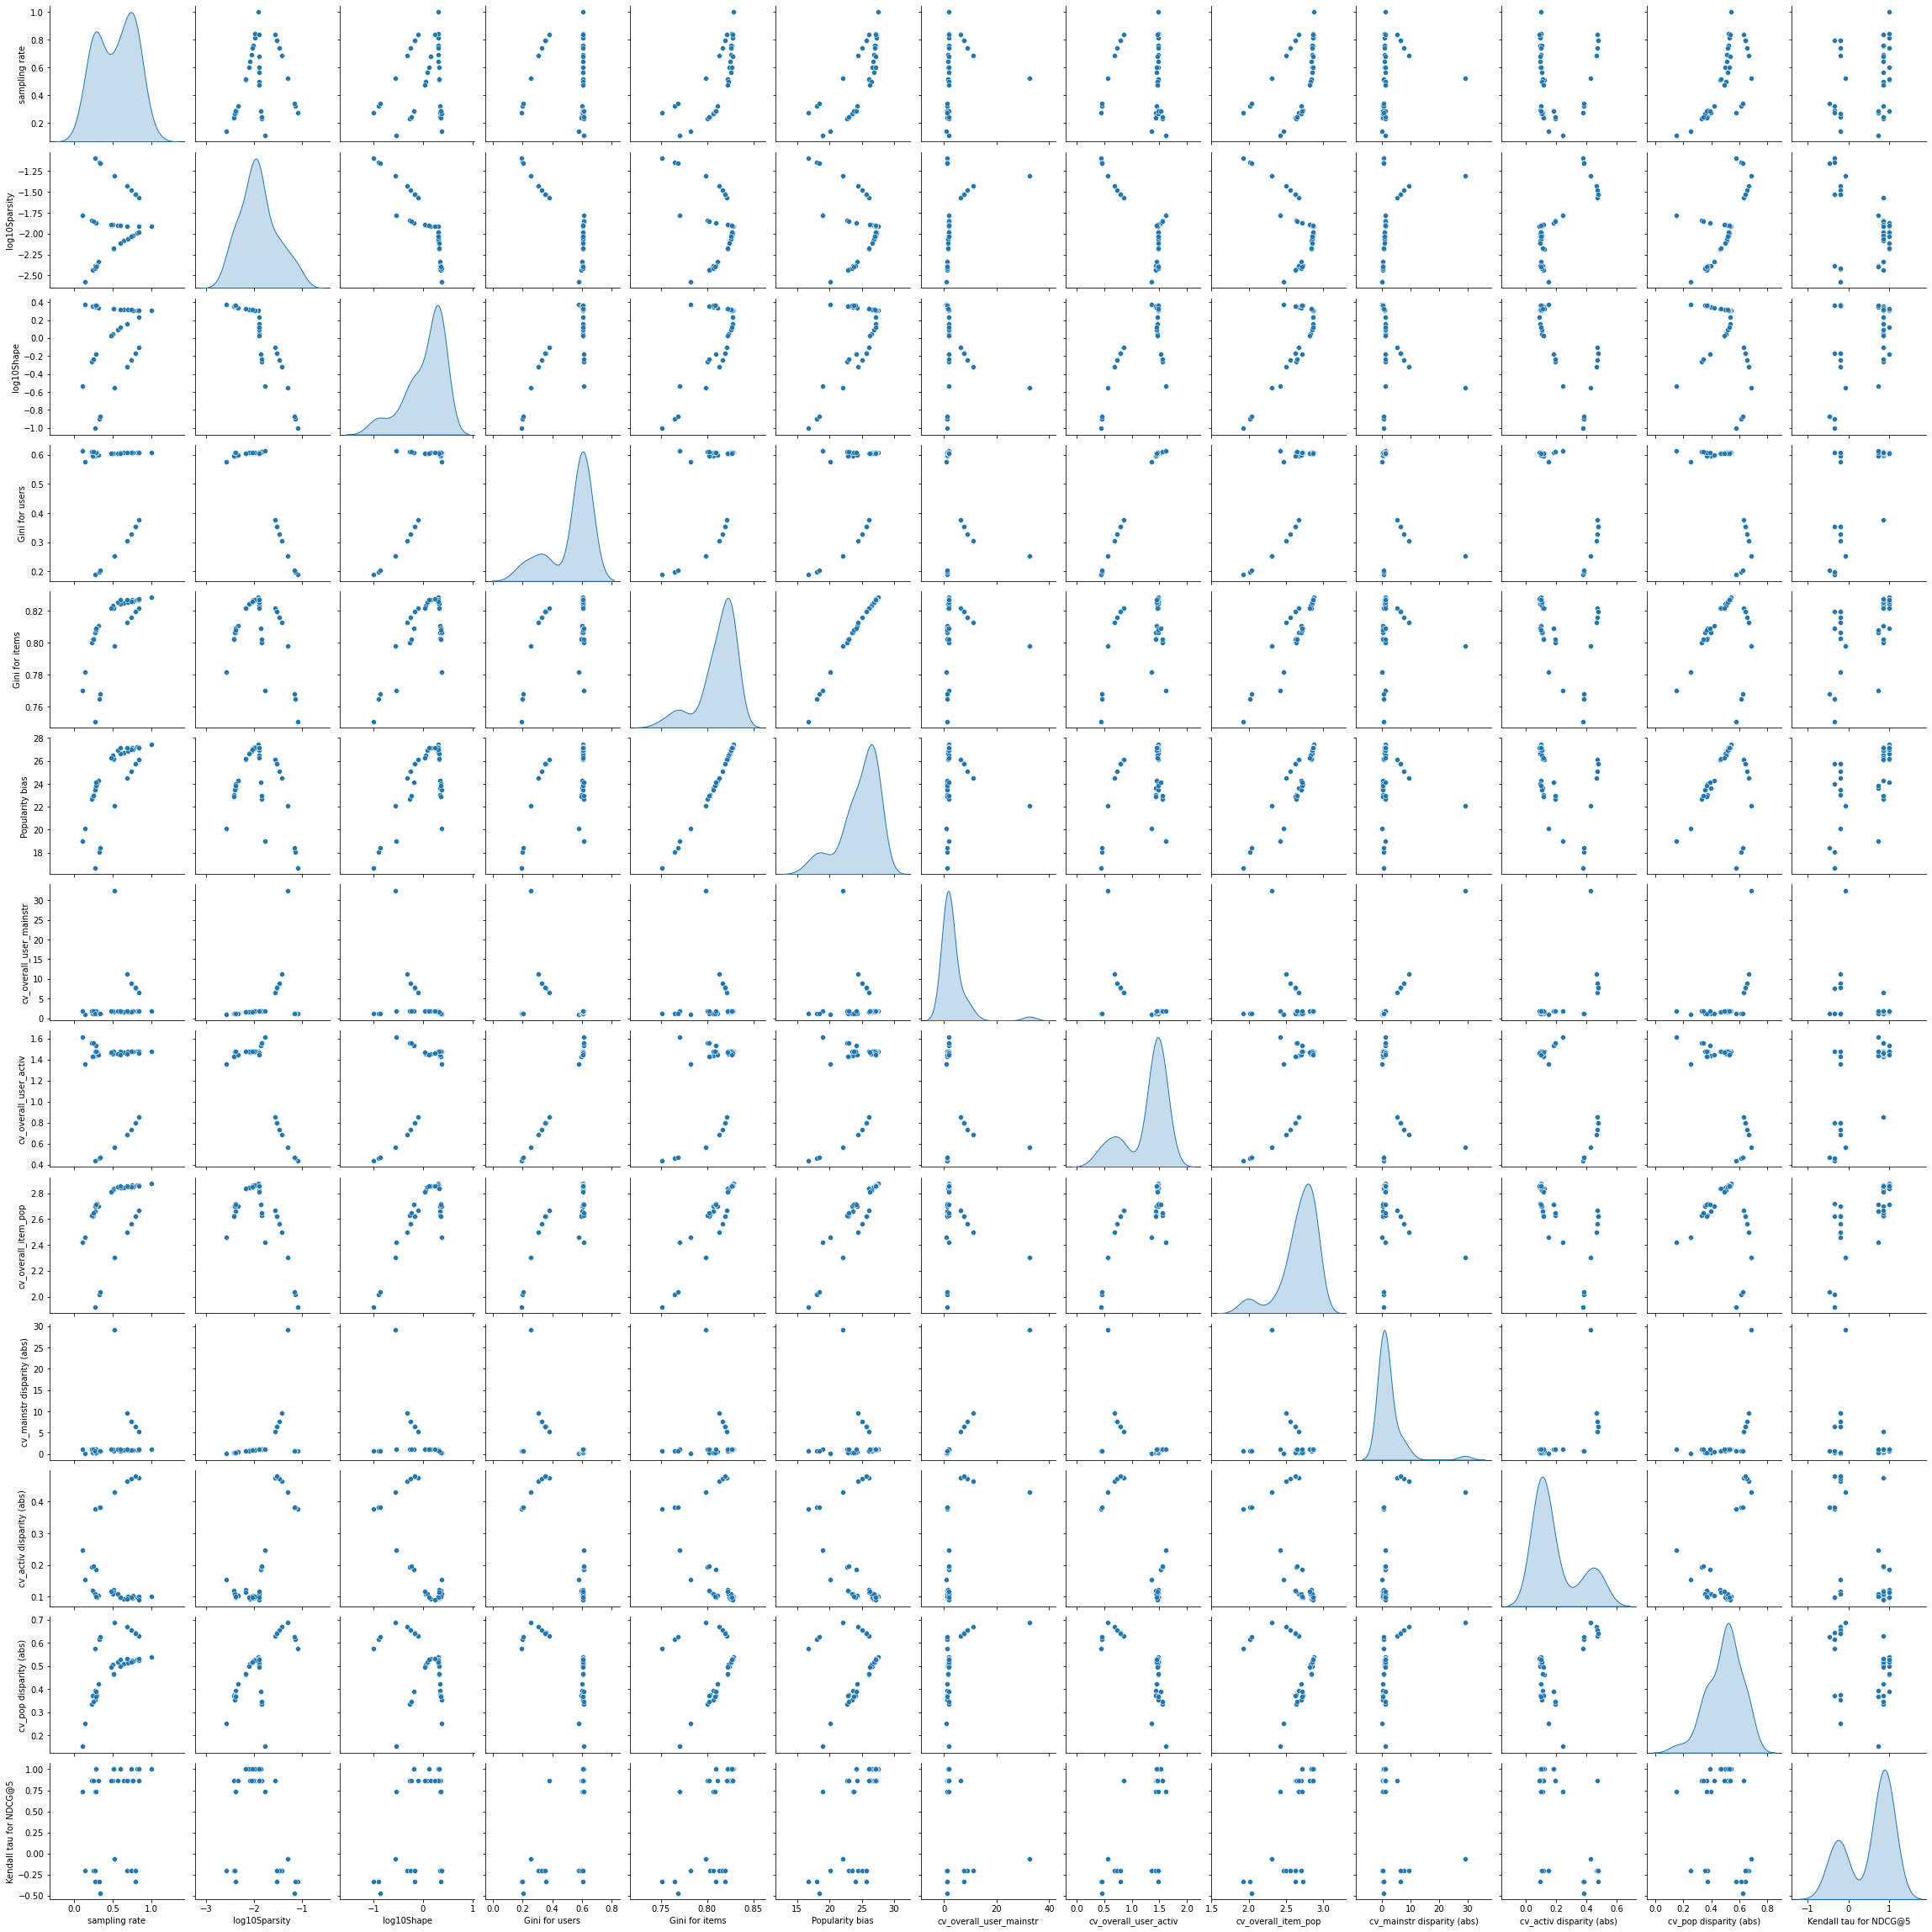

In [10]:
sns.pairplot(df[[
    'sampling rate',
    'log10Sparsity',
    'log10Shape',
    'Gini for users',
    'Gini for items',
    'Popularity bias',
    'cv_overall_user_mainstr',
    'cv_overall_user_activ',
    'cv_overall_item_pop',
    'cv_mainstr disparity (abs)',
    'cv_activ disparity (abs)',
    'cv_pop disparity (abs)',
    'Kendall tau for NDCG@5'
    ]], diag_kind='kde')
plt.savefig('/drive/My Drive/Colab Notebooks/dataset.png')

Discover Causality Graph using LiNGAM

In [8]:
graphs = {}
labels = [f'{col}' for i, col in enumerate(df.columns)]
obj = lingam.DirectLiNGAM()
obj.fit(df)
adj_matrix = obj.adjacency_matrix_
graph_dot = make_dot(adj_matrix, labels=labels)
# Save png
graph_dot.format = 'png'
graph_dot.render('/drive/My Drive/Colab Notebooks/causal_graph')

'/drive/My Drive/Colab Notebooks/causal_graph.png'

Obtain valid dot format

In [22]:
graph_dot_str = str_to_dot(graph_dot.source)
print(graph_dot_str)

digraph {"cv_activ disparity (abs)" -> log10Sparsity [label=1.58];log10Sparsity -> log10Shape [label=-0.66];"Gini for items" -> log10Shape [label=7.31];cv_overall_item_pop -> "Gini for users" [label=0.23];"cv_activ disparity (abs)" -> "Gini for users" [label=-0.33];"cv_pop disparity (abs)" -> "Gini for users" [label=-0.28];"sampling rate" -> "Gini for items" [label=0.06];"cv_activ disparity (abs)" -> "Gini for items" [label=-0.06];"Gini for items" -> "Popularity bias" [label=125.83];"cv_mainstr disparity (abs)" -> cv_overall_user_mainstr [label=1.08];"Gini for users" -> cv_overall_user_activ [label=2.30];log10Sparsity -> cv_overall_item_pop [label=-0.08];"Gini for items" -> cv_overall_item_pop [label=8.99];"cv_activ disparity (abs)" -> cv_overall_item_pop [label=-0.32];"cv_activ disparity (abs)" -> "cv_mainstr disparity (abs)" [label=14.64];"sampling rate" -> "cv_pop disparity (abs)" [label=0.18];log10Sparsity -> "cv_pop disparity (abs)" [label=0.07];"Gini for items" -> "cv_pop dispari

Define treatment and output

In [23]:
treatment='cv_overall_item_pop'
outcome='Kendall tau for NDCG@5'

Define Causal Inference Model

In [25]:
model=CausalModel(
        data = df,
        treatment=treatment,
        outcome=outcome,
        graph=graph_dot_str)
# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True,optimize_backdoor=True)
print(identified_estimand)
# Estimation
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression"
                                )

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                   
─────────────────────(Expectation(Kendall tau for NDCG@5|cv_activ disparity (a
d[cvₒᵥₑᵣₐₗₗ ᵢₜₑₘ ₚₒₚ]                                                         

     
bs)))
     
Estimand assumption 1, Unconfoundedness: If U→{cv_overall_item_pop} and U→Kendall tau for NDCG@5 then P(Kendall tau for NDCG@5|cv_overall_item_pop,cv_activ disparity (abs),U) = P(Kendall tau for NDCG@5|cv_overall_item_pop,cv_activ disparity (abs))

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


Refutation Checks

In [26]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", random_seed = 1)
print(res_random)
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute", random_seed = 1)
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

Textual Interpreter

In [27]:
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [cv_overall_item_pop] from 0 to 1 causes an increase of 1.1085387342714732 in the expected value of the outcome [Kendall tau for NDCG@5], over the data distribution/population represented by the dataset.


Causal Plot 

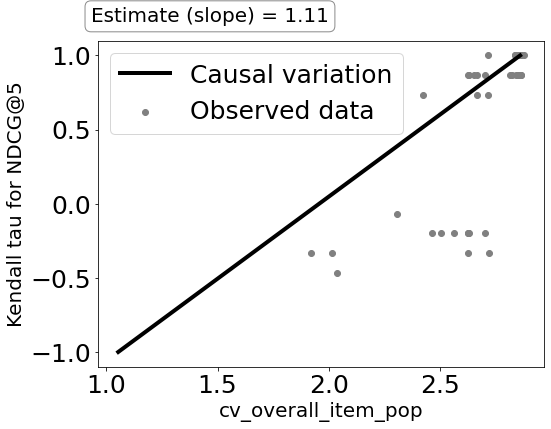

In [38]:
my_plot_causal_effect(estimate, treatment, outcome, df[treatment], df[outcome]) 